In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys
import random
import math
import numpy as np
import skimage.io
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2gray
from skimage import feature
import cv2
from sklearn.svm import LinearSVC
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import copy
from skimage.io import imread
from skimage.transform import resize
import pandas as pd

In [ ]:
DATADIR = "/content/drive/My Drive/pestdet/Dataset"
CATEGORIES = ["Brown Plant Hopper", "Rice Gall Midge", "Rice Leaf Hopper", "Rice Leaf Roller", "Stem Borer"]

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(DATADIR, 'Train')
validation_dir = os.path.join(DATADIR, 'Valid')
test_dir = os.path.join(DATADIR, 'Test')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20)
        
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20)

Found 1400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/xception_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-01-17 11:14:02--  https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83683744 (80M) [application/octet-stream]
Saving to: ‘/tmp/xception_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/xception_weigh 100%[===================>]  79.81M   228MB/s    in 0.4s    

2022-01-17 11:14:03 (228 MB/s) - ‘/tmp/xception_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [83683744/83683744]



In [ ]:
from tensorflow.keras.applications.xception import Xception

local_weights_file = '/tmp/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = Xception(
    input_shape=(150, 150,3), include_top=False, weights='imagenet')
pre_trained_model.load_weights(local_weights_file)

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.layers[-1]
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 5, 5, 2048)


In [ ]:
from keras import backend as K

K.clear_session()

In [ ]:
from tensorflow.keras.optimizers import RMSprop
#x = pre_trained_model.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

#x=GlobalAveragePooling2D()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='xception.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    #keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=20,
      epochs=16,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=1,
      callbacks = callbacks_list)

Epoch 1/16
20/20 [==============================] - ETA: 0s - loss: 5.1214 - acc: 0.4275
Epoch 00001: val_loss improved from inf to 1.31688, saving model to xception.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


20/20 [==============================] - 114s 6s/step - loss: 5.1214 - acc: 0.4275 - val_loss: 1.3169 - val_acc: 0.6300
Epoch 2/16
20/20 [==============================] - ETA: 0s - loss: 1.7858 - acc: 0.5800
Epoch 00002: val_loss improved from 1.31688 to 1.09284, saving model to xception.h5
20/20 [==============================] - 72s 4s/step - loss: 1.7858 - acc: 0.5800 - val_loss: 1.0928 - val_acc: 0.7000
Epoch 3/16
20/20 [==============================] - ETA: 0s - loss: 1.3843 - acc: 0.6175
Epoch 00003: val_loss improved from 1.09284 to 0.54966, saving model to xception.h5
20/20 [==============================] - 57s 3s/step - loss: 1.3843 - acc: 0.6175 - val_loss: 0.5497 - val_acc: 0.7700
Epoch 4/16
20/20 [==============================] - ETA: 0s - loss: 1.2774 - acc: 0.6600
Epoch 00004: val_loss did not improve from 0.54966
20/20 [==============================] - 54s 3s/step - loss: 1.2774 - acc: 0.6600 - val_loss: 0.5738 - val_acc: 0.7800
Epoch 5/16
20/20 [===================

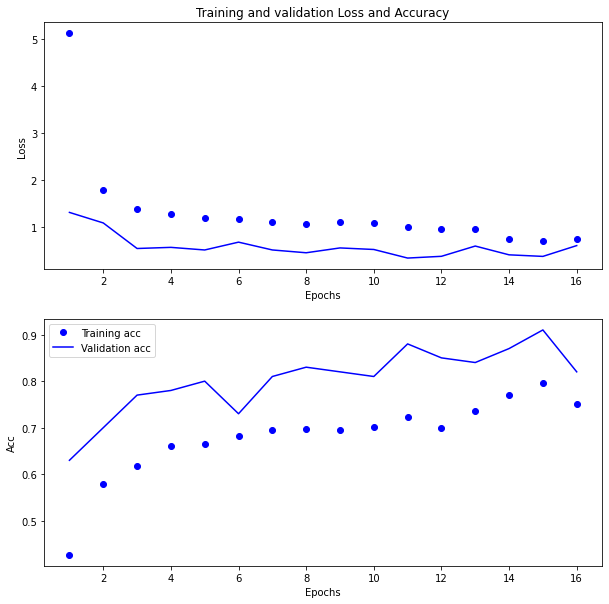

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('xception.h5')

In [ ]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

5/5 [==============================] - 8s 1s/step - loss: 0.3464 - acc: 0.8800
Val loss: 0.3463784158229828
Val accuracy: 0.8799999952316284


In [ ]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 2s 409ms/step - loss: 0.0219 - acc: 1.0000
Test loss: 0.02186591923236847
Test accuracy: 1.0


In [ ]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification Report
                    precision    recall  f1-score   support

Brown Plant Hopper       0.40      0.40      0.40         5
   Rice Gall Midge       0.00      0.00      0.00         5
  Rice Leaf Hopper       0.00      0.00      0.00         5
  Rice Leaf Roller       0.40      0.40      0.40         5
        Stem Borer       0.20      0.20      0.20         5

          accuracy                           0.20        25
         macro avg       0.20      0.20      0.20        25
      weighted avg       0.20      0.20      0.20        25



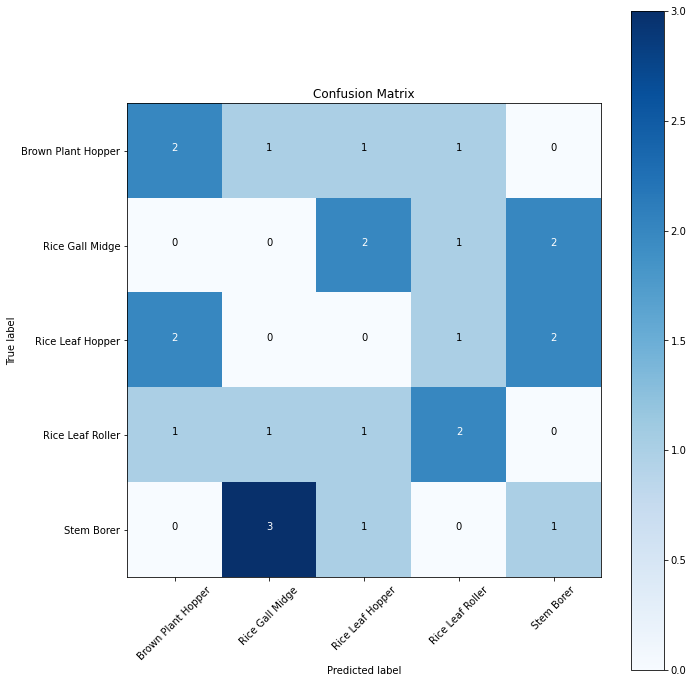

In [ ]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ["Brown Plant Hopper", "Rice Gall Midge", "Rice Leaf Hopper", "Rice Leaf Roller", "Stem Borer"]

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

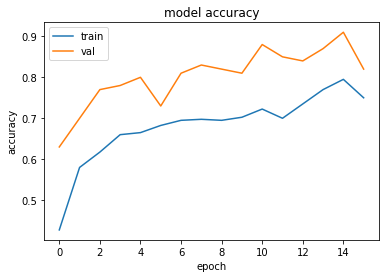

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

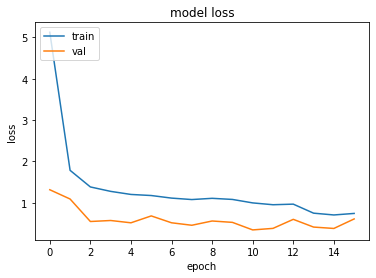

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Confusion Matrix
[[2 0 0 3 0]
 [0 3 0 1 1]
 [2 0 1 0 2]
 [0 1 4 0 0]
 [1 1 0 1 2]]
Classification Report
                    precision    recall  f1-score   support

Brown Plant Hopper       0.40      0.40      0.40         5
   Rice Gall Midge       0.60      0.60      0.60         5
  Rice Leaf Hopper       0.20      0.20      0.20         5
  Rice Leaf Roller       0.00      0.00      0.00         5
        Stem Borer       0.40      0.40      0.40         5

          accuracy                           0.32        25
         macro avg       0.32      0.32      0.32        25
      weighted avg       0.32      0.32      0.32        25



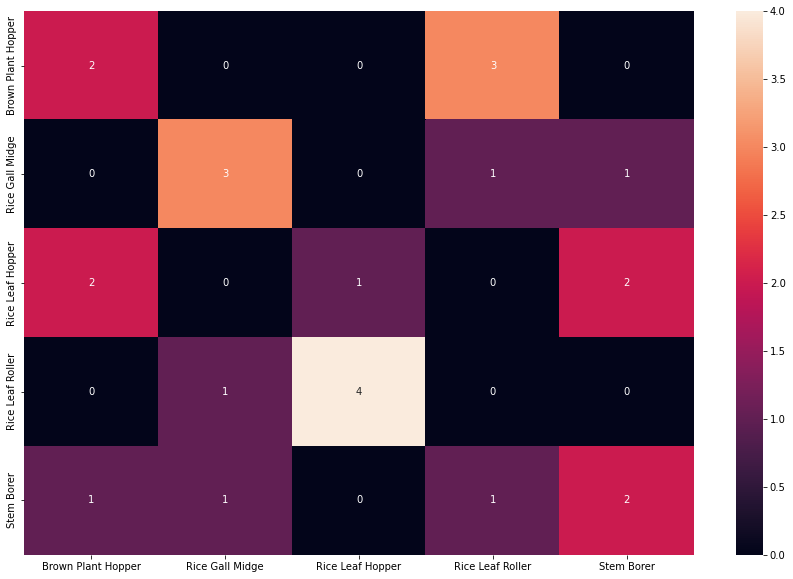

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(test_generator, 100//20+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm= confusion_matrix(test_generator.classes, y_pred)
print(cm)

target_names = ["Brown Plant Hopper", "Rice Gall Midge", "Rice Leaf Hopper", "Rice Leaf Roller", "Stem Borer"]

array= cm
df_cm = pd.DataFrame(array, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))